# Week 5 — NLP in the Wild: Sentiment + Confidence Lab (API-based)

This notebook analyzes **API-based sentiment classification** results generated by your project.

It reads two artifacts from the repo root:
- `outputs/sentiment_results.jsonl` (raw per-text results)
- `outputs/confidence_summary.json` (derived stability + confidence metrics)

It then visualizes:
- label distribution
- confidence distribution
- latency distribution
- which texts are flagged for review under your chosen confidence threshold

> **Note:** This notebook is **read-only by default** (no API calls). There is an optional cell to re-run a batch if you want to regenerate outputs (costs API calls).

In [2]:
from __future__ import annotations

import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

def find_repo_root(start: Path | None = None) -> Path:
    """Find repo root by walking upward until we see an 'outputs' directory or '.git'."""
    p = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (p / "outputs").exists() or (p / ".git").exists():
            return p
        p = p.parent
    raise RuntimeError("Could not find repo root. Run from within the repo.")

REPO_ROOT = find_repo_root()
OUTPUTS_DIR = REPO_ROOT / "outputs"

SENTIMENT_RESULTS_PATH = OUTPUTS_DIR / "sentiment_results.jsonl"
CONFIDENCE_SUMMARY_PATH = OUTPUTS_DIR / "confidence_summary.json"

REPO_ROOT, SENTIMENT_RESULTS_PATH, CONFIDENCE_SUMMARY_PATH

(WindowsPath('C:/Users/10260755/PycharmProjects/ain710-week5-nlp-in-the-wild'),
 WindowsPath('C:/Users/10260755/PycharmProjects/ain710-week5-nlp-in-the-wild/outputs/sentiment_results.jsonl'),
 WindowsPath('C:/Users/10260755/PycharmProjects/ain710-week5-nlp-in-the-wild/outputs/confidence_summary.json'))

In [3]:
# Load sentiment results (JSONL)
if not SENTIMENT_RESULTS_PATH.exists():
    raise FileNotFoundError(f"Missing: {SENTIMENT_RESULTS_PATH}. Run the batch script first.")

df = pd.read_json(SENTIMENT_RESULTS_PATH, lines=True)
df.head()

,run_id,project,model,item_index,run_index,text,label,confidence,rationale,elapsed_ms,response_id,logprobs_included
0,run_20260204T042142Z_1dcca67c,ain710-week5-nlp-in-the-wild,gpt-5.2,0,0,"I love the design, but the setup was frustrating.",neutral,0.66,Expresses both positive sentiment ('love the d...,1900.4593,resp_0390c7aa1e5a9cb6006982c9575f40819f87548d2...,True
1,run_20260204T042142Z_1dcca67c,ain710-week5-nlp-in-the-wild,gpt-5.2,1,0,This was a complete waste of time.,negative,0.98,"The text expresses strong dissatisfaction, cal...",1315.2966,resp_0a0e3beafd768e37006982c958f87c81949ee5e76...,True
2,run_20260204T042142Z_1dcca67c,ain710-week5-nlp-in-the-wild,gpt-5.2,2,0,Absolutely fantastic experience — would recomm...,positive,0.98,"Uses strongly positive language: ""Absolutely f...",2132.1301,resp_0348fbd6580890af006982c95b0650819094f940a...,True
3,run_20260204T042142Z_1dcca67c,ain710-week5-nlp-in-the-wild,gpt-5.2,3,0,"Yeah, great… just what I needed (eye roll).",negative,0.93,"The phrase ""Yeah, great… just what I needed"" w...",1293.2869,resp_0c1b33db5ddc65a2006982c95cf45081a38e3c919...,True
4,run_20260204T042240Z_245bb82e,ain710-week5-nlp-in-the-wild,gpt-5.2,0,0,"I love the design, but the setup was frustrating.",neutral,0.62,Expresses both positive sentiment ('love the d...,2147.7101,resp_01ed049d983830fb006982c9917558819081418ef...,True


## Basic sanity checks

We expect:
- `label` in {positive, neutral, negative}
- `confidence` in [0, 1]
- `elapsed_ms` positive
- stable grouping keys: `text`, `item_index`, `run_index`, `run_id`

In [4]:
df['label'].value_counts()

label
negative    4
neutral     2
positive    2
Name: count, dtype: int64

In [5]:
df[['confidence', 'elapsed_ms']].describe()

,confidence,elapsed_ms
count,8.000000,8.000000
mean,0.882500,1684.360338
std,0.151634,487.553792
min,0.620000,1135.036100
25%,0.862500,1277.526975
50%,0.955000,1607.877950
75%,0.980000,2136.025100
max,0.980000,2320.716400


## Visualize label distribution

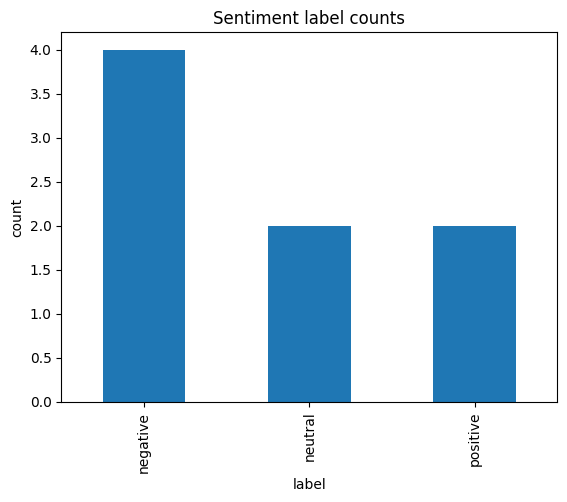

In [6]:
ax = df['label'].value_counts().plot(kind='bar')
ax.set_title('Sentiment label counts')
ax.set_xlabel('label')
ax.set_ylabel('count')
plt.show()

## Confidence distribution

This shows how strongly the model *claims* to believe each classification.
In your discussion post, you can connect this to the idea that **labels alone hide uncertainty**.

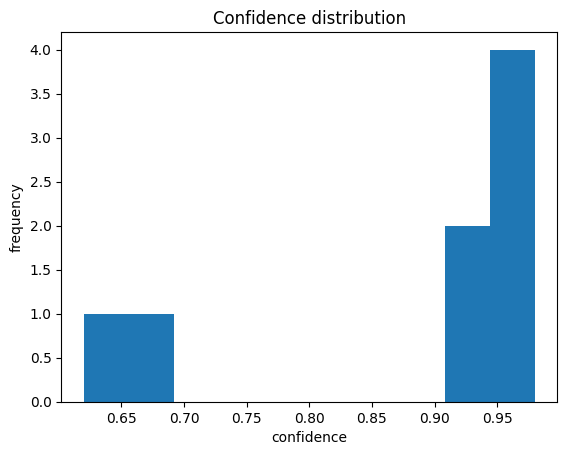

In [7]:
ax = df['confidence'].plot(kind='hist', bins=10)
ax.set_title('Confidence distribution')
ax.set_xlabel('confidence')
ax.set_ylabel('frequency')
plt.show()

## Latency distribution (`elapsed_ms`)

This helps you talk about real-world operational constraints: responsiveness, cost, and monitoring.

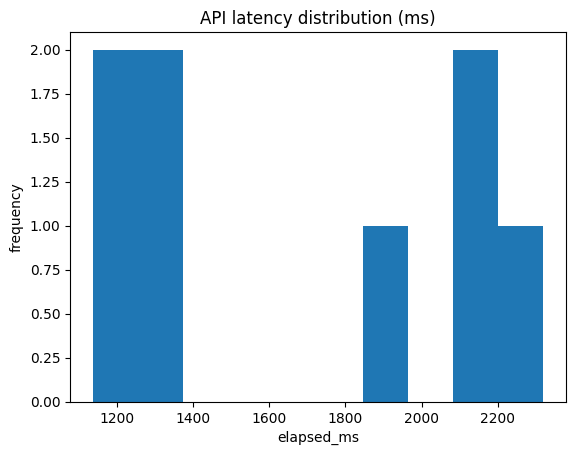

In [8]:
ax = df['elapsed_ms'].plot(kind='hist', bins=10)
ax.set_title('API latency distribution (ms)')
ax.set_xlabel('elapsed_ms')
ax.set_ylabel('frequency')
plt.show()

## Per-text view (for "NLP in the Wild" narrative)

This table is easy to screenshot or summarize in your discussion post.

In [9]:
cols = ['text', 'label', 'confidence', 'elapsed_ms', 'run_id', 'item_index', 'run_index']
df[cols].sort_values(['item_index','run_index']).reset_index(drop=True)

,text,label,confidence,elapsed_ms,run_id,item_index,run_index
0,"I love the design, but the setup was frustrating.",neutral,0.66,1900.4593,run_20260204T042142Z_1dcca67c,0,0
1,"I love the design, but the setup was frustrating.",neutral,0.62,2147.7101,run_20260204T042240Z_245bb82e,0,0
2,This was a complete waste of time.,negative,0.98,1315.2966,run_20260204T042142Z_1dcca67c,1,0
3,This was a complete waste of time.,negative,0.98,1135.0361,run_20260204T042240Z_245bb82e,1,0
4,Absolutely fantastic experience — would recomm...,positive,0.98,2132.1301,run_20260204T042142Z_1dcca67c,2,0
5,Absolutely fantastic experience — would recomm...,positive,0.98,1230.2472,run_20260204T042240Z_245bb82e,2,0
6,"Yeah, great… just what I needed (eye roll).",negative,0.93,1293.2869,run_20260204T042142Z_1dcca67c,3,0
7,"Yeah, great… just what I needed (eye roll).",negative,0.93,2320.7164,run_20260204T042240Z_245bb82e,3,0


## Load derived confidence/stability summary

This summary is computed by `src/lab/confidence.py` and is where your governance threshold shows up.

If you used `low_conf_threshold=0.70`, mixed/ambiguous texts should be flagged for review.

In [10]:
if not CONFIDENCE_SUMMARY_PATH.exists():
    raise FileNotFoundError(f"Missing: {CONFIDENCE_SUMMARY_PATH}. Run run_confidence.py first.")

with CONFIDENCE_SUMMARY_PATH.open('r', encoding='utf-8') as f:
    summaries = json.load(f)

df_sum = pd.DataFrame(summaries)
df_sum.sort_values('confidence_mean')

,group_by,group_key,n_runs,label_mode,label_mode_count,label_flip_count,label_flip_rate,confidence_mean,confidence_std,confidence_min,confidence_max,low_confidence_flag,unstable_flag,project,model
1,text,"I love the design, but the setup was frustrating.",2,neutral,2,0,0.0,0.64,0.02,0.62,0.66,True,False,ain710-week5-nlp-in-the-wild,gpt-5.2
3,text,"Yeah, great… just what I needed (eye roll).",2,negative,2,0,0.0,0.93,0.00,0.93,0.93,False,False,ain710-week5-nlp-in-the-wild,gpt-5.2
0,text,Absolutely fantastic experience — would recomm...,2,positive,2,0,0.0,0.98,0.00,0.98,0.98,False,False,ain710-week5-nlp-in-the-wild,gpt-5.2
2,text,This was a complete waste of time.,2,negative,2,0,0.0,0.98,0.00,0.98,0.98,False,False,ain710-week5-nlp-in-the-wild,gpt-5.2


## Flagged for review

These are the items where your policy says: **"Don’t trust the label alone — route to review."**

In [11]:
df_sum[df_sum['low_confidence_flag'] == True].sort_values('confidence_mean')

,group_by,group_key,n_runs,label_mode,label_mode_count,label_flip_count,label_flip_rate,confidence_mean,confidence_std,confidence_min,confidence_max,low_confidence_flag,unstable_flag,project,model
1,text,"I love the design, but the setup was frustrating.",2,neutral,2,0,0.0,0.64,0.02,0.62,0.66,True,False,ain710-week5-nlp-in-the-wild,gpt-5.2


## Optional: Re-run batch (costs API calls)

Uncomment and run this cell only if you want to regenerate results.

Tip: set `n_runs_per_text=5` to make stability/variance more interesting.

In [12]:
# from src.lab.sentiment import build_default_context
# from src.lab.sentiment_batch import BatchConfig, run_sentiment_batch
#
# ctx = build_default_context()
#
# results = run_sentiment_batch(
#     ctx=ctx,
#     texts=[
#         "I love the design, but the setup was frustrating.",
#         "This was a complete waste of time.",
#         "Absolutely fantastic experience — would recommend.",
#         "Yeah, great… just what I needed (eye roll).",
#     ],
#     config=BatchConfig(n_runs_per_text=5, temperature=0.7, write_results_jsonl=True),
# )
#
# print(f"Wrote {len(results)} records to: {OUTPUTS_DIR / 'sentiment_results.jsonl'}")

## Discussion-post hooks (copy/paste ideas)

- **Label vs confidence:** show that mixed sentiment can be labeled consistently but with lower confidence.
- **Operational reality:** latency varies; monitoring and fallbacks matter.
- **Governance:** define a threshold (e.g., 0.70) where ambiguous outputs route to human review.
- **Bias/insensitivity:** propose test sets with dialect, sarcasm, idioms, and domain language; measure label flips and confidence drops.